## Assignment 9: Geographic visualization with Python

In this assignment, the second-to-last of the semester, we will venture outside of the Python ecosystem to create interactive maps with Mapbox Studio.  You'll be making an interactive map of public intoxication violations in Fort Worth, drawn from the same City crime dataset you worked with in Assignment 7.  You'll explore methods for visualizing large amounts of point data and customize your map's appearance..  

In this instance, you are going to upload a bulk CSV download that I've prepared for you from the City's open data catalog.  The data as currently constituted are not quite ready for use in Mapbox Studio, so we're going to clean it up a bit in `pandas` first.  

Mapbox Studio accepts data in many formats, such as CSV, GeoJSON, and zipped shapefile.   In this instance, our data are in CSV format.  Let's read the data into `pandas` and have a look.  

In [1]:
import pandas as pd

# Modify the path below to your data path
df = pd.read_csv("data/fort_worth_crime_extract.csv")

df.head()

,Case and Offense,Case Number,Reported Date,Nature Of Call,From Date,Offense,Description,Block Address,City,State,Beat,Division,Council District,Attempt Complete,Location Type,Location Description,Location
0,200025542-90E,200025542,03/28/2020,PUBLIC INTOXICATION,03/28/2020 11:50:00 PM,90E,GC 080 Public Intoxication 90E DRUNKENNESS 000...,200 NE 28TH ST,FORT WORTH,TX,C11,Northwest,2.0,C,18,18 PARKING LOT/GARAGE,"(32.79512267527676, -97.34736968390531)"
1,200025291-90E,200025291,03/27/2020,PUBLIC INTOXICATION,03/27/2020 08:29:28 PM,90E,GC 080 Public Intoxication 90E DRUNKENNESS 000...,14300 CENTREPORT LANDING CIR,FORT WORTH,TX,H17,NaN,NaN,C,20,20 RESIDENCE/HOME,"(32.81901915935712, -97.05732878148257)"
2,200025472-35A,200025472,03/28/2020,PUBLIC INTOXICATION,03/28/2020 04:41:22 PM,35A,HSC 481.117(B) Poss CS PG 3 <28G 35A DRUG/NARC...,5400 ENCLAVE CIR,FORT WORTH,TX,K18,NaN,NaN,C,15,15 JAIL/PRISON,"(32.67383727899393, -97.41089914948881)"
3,200025309-90E,200025309,03/27/2020,PUBLIC INTOXICATION,03/27/2020 09:11:59 PM,90E,GC 080 Public Intoxication 90E DRUNKENNESS 000...,3300 W BOYCE AVE,FORT WORTH,TX,J12,South,9.0,C,20,20 RESIDENCE/HOME,"(32.68139719413715, -97.36576854742505)"
4,200025525-90E,200025525,03/28/2020,PUBLIC INTOXICATION,03/28/2020 10:54:17 PM,90E,GC 080 Public Intoxication 90E DRUNKENNESS 000...,100 E BOLT ST,FORT WORTH,TX,I11,NaN,NaN,C,13,13 HIGHWAY/ROAD/ALLEY,"(32.68865080126258, -97.3265765609558)"


Scroll to the right-hand side of your data frame to view the `Location` column.  You'll notice that it is formatted as latitude/longitude coordinate pairs, separated by a comma and enclosed in parentheses.  Additionally, some of the latitude/longitude values are missing.  

In [2]:
null_rows = pd.isnull(df.Location)

null_rows.value_counts()

Location
False    1979
True       44
Name: count, dtype: int64

It looks like 44 rows in our dataset are missing latitude and longitude information.  In a regular data analysis workflow, you'd want to do some investigation of these missing values, and ultimately see if there is any systematic bias there.  Another option would be to try to locate as many of these missing values as possible.  As our focus here is learning mapping in Mapbox Studio, however, let's forge ahead.  

To map CSV data, Mapbox Studio requires that one column contain the longitude coordinates, and one column contain the latitude coordinates.  As such, we'll need to get rid of the parentheses in the column, then split the column into two columns, and finally add those columns back to our data frame.  Study the code below to examine what it does: 

In [3]:
# Loop through the characters in the string we want to replace, and replace them in turn
for char in ['(', ')']: 
    df['Location'] = df.Location.str.replace(char, '')

# Split our `Location_1` column at the comma with the `.split()` method;
# the `expand = True` argument returns a new data frame
locs = df.Location.str.split(',', expand = True)

locs.columns = ['latitude', 'longitude']

# Add these new columns to our existing data frame with the
# `pd.concat` method, to which we pass a list of data frames;
# specifying `axis = 1` makes sure that we combine columns, not
# rows.
df2 = pd.concat([df, locs], axis = 1)

df2.head()

,Case and Offense,Case Number,Reported Date,Nature Of Call,From Date,Offense,Description,Block Address,City,State,Beat,Division,Council District,Attempt Complete,Location Type,Location Description,Location,latitude,longitude
0,200025542-90E,200025542,03/28/2020,PUBLIC INTOXICATION,03/28/2020 11:50:00 PM,90E,GC 080 Public Intoxication 90E DRUNKENNESS 000...,200 NE 28TH ST,FORT WORTH,TX,C11,Northwest,2.0,C,18,18 PARKING LOT/GARAGE,"32.79512267527676, -97.34736968390531",32.79512267527676,-97.34736968390531
1,200025291-90E,200025291,03/27/2020,PUBLIC INTOXICATION,03/27/2020 08:29:28 PM,90E,GC 080 Public Intoxication 90E DRUNKENNESS 000...,14300 CENTREPORT LANDING CIR,FORT WORTH,TX,H17,NaN,NaN,C,20,20 RESIDENCE/HOME,"32.81901915935712, -97.05732878148257",32.81901915935712,-97.05732878148257
2,200025472-35A,200025472,03/28/2020,PUBLIC INTOXICATION,03/28/2020 04:41:22 PM,35A,HSC 481.117(B) Poss CS PG 3 <28G 35A DRUG/NARC...,5400 ENCLAVE CIR,FORT WORTH,TX,K18,NaN,NaN,C,15,15 JAIL/PRISON,"32.67383727899393, -97.41089914948881",32.67383727899393,-97.41089914948881
3,200025309-90E,200025309,03/27/2020,PUBLIC INTOXICATION,03/27/2020 09:11:59 PM,90E,GC 080 Public Intoxication 90E DRUNKENNESS 000...,3300 W BOYCE AVE,FORT WORTH,TX,J12,South,9.0,C,20,20 RESIDENCE/HOME,"32.68139719413715, -97.36576854742505",32.68139719413715,-97.36576854742505
4,200025525-90E,200025525,03/28/2020,PUBLIC INTOXICATION,03/28/2020 10:54:17 PM,90E,GC 080 Public Intoxication 90E DRUNKENNESS 000...,100 E BOLT ST,FORT WORTH,TX,I11,NaN,NaN,C,13,13 HIGHWAY/ROAD/ALLEY,"32.68865080126258, -97.3265765609558",32.68865080126258,-97.3265765609558


Success!  We can now write our location-aware data frame to a CSV, for use in Mapbox Studio.  

In [5]:
import geopandas as gp

geo_df = gp.GeoDataFrame(data = df2, geometry = gp.points_from_xy(df2.longitude, df2.latitude), crs = 4326)

geo_df.head()

CRSError: Invalid projection: EPSG:4326: (Internal Proj Error: proj_create: no database context specified)

In [6]:
gp.show_versions()


SYSTEM INFO
-----------
python     : 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:37:07) [Clang 15.0.7 ]
executable : /Users/kylewalker/anaconda3/envs/geospatial/bin/python
machine    : macOS-13.3-arm64-arm-64bit

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : 3.12.0
GEOS lib   : None
GDAL       : 3.7.3
GDAL data dir: /Users/kylewalker/anaconda3/envs/geospatial/share/gdal
PROJ       : 9.3.0
PROJ data dir: /Users/kylewalker/anaconda3/share/proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.14.0
numpy      : 1.26.0
pandas     : 2.1.2
pyproj     : 3.6.1
shapely    : 2.0.2
fiona      : 1.9.5
geoalchemy2: None
geopy      : None
matplotlib : 3.8.1
mapclassify: 2.6.1
pygeos     : None
pyogrio    : None
psycopg2   : None
pyarrow    : None
rtree      : 1.1.0


When you run this cell, `pandas` will write a CSV file named `intoxication.csv` in your top-level directory in Colab.  Go find it by clicking the folder icon and expand its options; you'll get an option to download the file to the computer, which should default to your Downloads directory.  

Let's now head over to Mapbox Studio at http://studio.mapbox.com.  

## Setting up a Style in Mapbox Studio

If you don't yet have a Mapbox Studio account, go ahead and sign up for one by clicking the "Sign up for Mapbox" link from the "Sign in" screen.  All you need to do is specify a username, email address, and password and agree to the Terms of Service, and you are good to go. Once you've established your account, you'll be taken to the Mapbox Studio splash screen, which defaults to the "Styles" tab.  You won't see any styles as you haven't created any yet.  Click the "New style" button to get started. 

<img src=img/styles1.png width = "1000px">

View the different templates available to you.  Given that we are plotting data over a basemap layer, I'd recommend using a template with more muted colors; I have a preference for the "Monochrome - Light" version given the way we'll be visualizing our data but I'll let you choose the template you like best.  Once you've selected a basemap template, click the "Customize" button to advance to the Mapbox Studio editor.  

<img src=img/styles2.png width = "1000px">

In the map editor, pan over to the Fort Worth area and zoom in and out.  Mapbox Studio gives you access to _vector tiles_, which are variants of the tiled mapping structure we've discussed in class but which expose the underlying data rather than simply showing images.  This allows for the customization of any component of the map.  You'll see a series of such "components" on the left-hand side of the screen.  They are organized into categories which you can explore and edit collectively.  Alternatively, you can view major categories and style them by clicking the "Colors" option in the lower left section of the screen and choosing a map element, then selecting a color from the interactive picker.  You can also click the "Layers" tab to view all of the individual map layers, and edit them one-by-one; you may need to "override" the color to do so.  Below, I show an example of the "Monochrome - Light" template where I've styled water features with a light blue and park features with a light green.  Experiment and try designing a map yourself!

![customized map](img/map1.png)

## Loading new data into Mapbox Studio

Now that you've spent some time exploring Mapbox Studio and customizing your map, let's add the public drunkenness data to the map as well to visualize it.  Follow these steps to upload your data and add it to the map: 

1. Click "Layers" on the left-hand side of the screen and look for the plus sign icon.  This will bring up the "New layer" menu.  
2. Look for the "Upload data" option and click there.  Locate your intoxication CSV file and drag and drop it on the dialog box, or click on "Select a file" and navigate to it on your computer.  You'll see the "New tileset" dialog appear; click __Confirm__ if the information is correct.
3. You'll see a "Notifications" box appear in the lower left corner of the screen, letting you know that your upload is processing.  Mapbox Studio is converting your public intoxication dataset into vector tiles, which is the same format that is used by the rest of the layers that you've been working with.  This will allow you to display your data along with those other layers on the map.
4. Once your upload has finished processing, scroll down the list of "Sources" to the bottom.  You should see your intoxication tile source appear as an option.  Click there to reveal the point layer within the tileset, then click the revealed layer to add it to your map.  You should see your points added to your map.  

<img src=img/add_tileset.png style="width: 1000px">

<br/>
<br/>

Once you've successfully added your tileset, click "Style" as instructed on the screen to style your layer.  

## Modifying visualization options for your tileset

By default, your points will show up as black dots on top of your basemap.  While this does show clusters of violations around the city, it is not the most visually pleasing representation of your data.  Let's make some modifications to the data representation to show it in an alternative way.  Feel free to experiment with different style options; you can modify the circle radius, the color, blur and opacity, and other characteristics.  

You are not limited to styling your point data as circles, however.  Click the "Select data" option once more (ensuring first that your intoxication layer is still selected) and click the __Type__ option.  From the options that appear, choose __Heatmap__.  Now, click __Style__ once more to style your data as a heatmap.  You'll note that your data no longer appears as points, but as a smoothed representation of where your points are concentrated.  My default view is the image below; yours may appear slightly different depending on how far you are currently zoomed in.

<img src=img/heatmap1.png style="width: 1000px">

The visualization defaults to a blue-to-red representation based on five colors, which each represent different density values.  The highest density value is scaled to 1, which is bright red; the lowest color value is 0.1 by default, colored blue.  Areas without violations are represented without color.  Try zooming in and out on your map to see how the heatmap changes based on zoom level. 

There are several ways we can make the map more legible, however; I'll outline a few here.  

1. When zoomed out to show the entire city, the high-density areas cover most of the urban core.  This limits our ability to show differentiation on the map.  To modify this, change the __Radius__ of your heatmap from the default 30 pixels and make it smaller.  Experiment with different radii and observe how the data representation changes on your map.

2. The default color representation, while mapping to perceptions of "hot" and "cold" is not colorblindness-safe.  Make some changes to the color values to use a colorblind-safe palette.  I recommend the __viridis__ family of color palettes, which are built into __seaborn__ for quick lookup.  There are five palettes in the viridis family: `viridis`, `magma`, `inferno`, `plasma`, and `cividis`.  All are color-blind safe, perceptually uniform, and safe to print in black and white.  Let's load in the palettes and take a look at them:


In [1]:
import seaborn as sns

viridis = sns.color_palette("viridis", 5).as_hex()
inferno = sns.color_palette("inferno", 5).as_hex()
magma = sns.color_palette("magma", 5).as_hex()
plasma = sns.color_palette("plasma", 5).as_hex()
cividis = sns.color_palette("cividis", 5).as_hex()

I've assigned five-color extracts from the palettes and converted them to hexadecimal representation, which is a common way to represent colors and can be used in Mapbox Studio.  Let's take a look at each palette in turn:

['#443983', '#31688e', '#21918c', '#35b779', '#90d743']


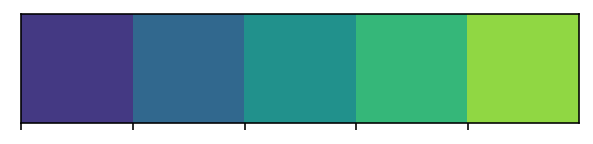

In [6]:
# viridis
print(viridis)
sns.palplot(viridis)

['#320a5e', '#781c6d', '#bc3754', '#ed6925', '#fbb61a']


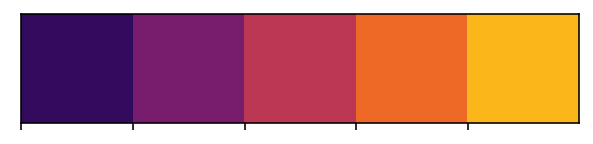

In [7]:
# inferno
print(inferno)
sns.palplot(inferno)

['#2c115f', '#721f81', '#b73779', '#f1605d', '#feb078']


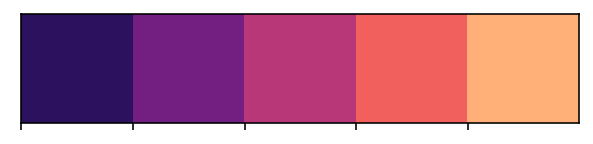

In [8]:
# magma
print(magma)
sns.palplot(magma)

['#5c01a6', '#9c179e', '#cc4778', '#ed7953', '#fdb42f']


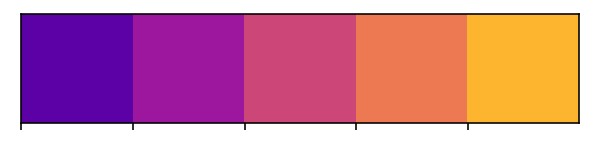

In [9]:
# plasma
print(plasma)
sns.palplot(plasma)

['#2a3f6d', '#575d6d', '#7d7c78', '#a59c74', '#d2c060']


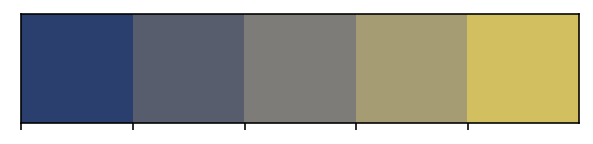

In [10]:
# cividis
print(cividis)
sns.palplot(cividis)

Each sequence ranges from cooler colors to warmer colors, making the colors appropriate for use on a heatmap.  In Mapbox Studio, select the __Color__ option to style your heatmap and click on the color that represents the value 0.1 ("royalblue").  You should see an interactive color picker appear with options to modify the color values directly.  Choose one of the five color palettes I've printed and copy the first six-digit hexadecimal code in the printed list (you don't need the number sign as it is already provided) to the corresponding box with the number sign to the lower right of the interactive color picker. You should see that color change on the map to your selected color.  

One-by-one, modify the five map colors using the hexadecimal codes from your selected color palette.  For example, this is what your map might look like using `inferno`: 

<img src=img/inferno.png style="width: 1000px">

If you'd like, you can also modify the "stops" that correspond to each color value to tune the color blending accordingly.



3. While the color scheme is now more appropriate, it is difficult to understand _where_ the concentrations of violations are because your heatmap is fully opaque.  Choose the __Opacity__ option and lower the value to make your heatmap layer semi-transparent.  You might also consider modifying the __Weight__ and __Intensity__ options to make your heatmap less intense.  Experiment with these different options until you achieve a representation that you like.  

4. Finally, integrate your heatmap's relationship better with the other map layers by modifying its positioning.  You may notice on the left-hand side of the screen that each element of the map - from map labels to roadways to water features - is represented in hierarchical order, with your heatmap layer sitting at the very top.  Click your intoxication layer in the layer list and drag it beneath all of the label layers (the last one listed is "road-label") and note how the visual hierarchy of your map changes, with labels above your heatmap.

## Sharing your map

Now that you've made modifications to your map visualization, it is ready to share!  Click the __Publish__ button in the top right corner of your screen to publish your map.  Once published, click __Continue editing__.  There are a couple different ways that you can share your map.  The __Print__ button allows you to export your map as a static image.  The __Share__ button gives you a series of options for sharing your map either as a standalone interactive map or as an embedded element in a mobile or web application.  Click __Share__, and note the URL which you can copy in the __Share style__ section.  Click the "Make Public" button to make your style share-able, then try copying this URL and pasting in a web browser; you'll see your map appear full-screen.  

Below this section, note the __Developer resources__.  This gives you some resources to embed your map in a website or a mobile application.  To complete this assignment, you'll get some small experience embedding the Mapbox map that you've designed in a stand-alone web page using Mapbox GL, Mapbox's web development library.

If you haven't already, download the HTML file from TCU Online named "example_map.html".  Open the HTML file in a text editor, not a web browser.  To do this, either right-click the downloaded file and choose an option to open the file in a text editor (e.g. Notepad on Windows or TextEdit on a Mac), or open the text editor first, choose __Open__, and navigate to your HTML file.  

You'll see some HTML code that I've copied from [the Mapbox "Display a map" tutorial](https://docs.mapbox.com/mapbox-gl-js/example/simple-map/).  You don't need to understand everything that is going on here, but I do want to get you some practice modifying it.  The HTML file is a text file that can be interpreted by web browsers and rendered as a website.  It can be downloaded and hosted on your personal website, for example.  

Look for the section inside the `<script></script>` tags that appears as below:

```html
<script>
  // Replace the access token below with your access token
	mapboxgl.accessToken = 'pk.eyJ1IjoidGVzdHN0dWRlbnQzMDMyMyIsImEiOiJjazhnMmh2YWcwYWVvM2VwY3FiNGJybnFsIn0.0LFUer_9q-B0TNYyt94QkA';
    var map = new mapboxgl.Map({
        container: 'map', // container id
        // Replace the style URL below with your style URL
        style: 'mapbox://styles/teststudent30323/ck8g4rcp93cr41is3qt51lryo',
        center: [-97.3079, 32.7388], // starting position [lng, lat]
        zoom: 11 // starting zoom
    });
</script>

```

Copy the "Access token" from your Share dialog in Mapbox Studio (it starts with "pk.") and replace the existing access token in the HTML code with your own.  Next, do the same for the style URL.  Save the map file, then try opening it in a web browser (navigate to the file through your computer's filesystem, then double-click the file to launch it). If it does not appear immediately, it is because the styles take a few moments to publish after you've first published them; you can add the text `/draft` directly after your style URL to view it right away (I have this example saved for illustration).

## For submission

To get credit for this assignment, modify the `example_map.html` file as instructed above with your Mapbox access token and style URL and upload your map file to the submission console in TCU Online. This will allow me to view your map!